In [2]:
!pip install matplotlib
!pip install numpy
!pip install notebook
!pip install tensorflow-addons
!pip install tensorflow-model-optimization
!pip install tensorflow==2.15.0
!pip install keras

In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tea data set sample",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 907 files belonging to 21 classes.


In [8]:
class_names = dataset.class_names
class_names

['Looper caterpillar  Feeding and Leaf Damage Stage 2',
 'Looper caterpillar Adult Moths Stage 5',
 'Looper caterpillar Initial Infestation Stage 1',
 'Looper caterpillar Population Growth Stage 3',
 'Looper caterpillar Pupal Stage Stage 4',
 'Red Slug Caterpillar Adult Stage 4',
 'Red Slug Caterpillar Egg  Stage 1',
 'Red Slug Caterpillar Larva Stage 2',
 'Red Slug Caterpillar Pupa stage 3',
 'Red spider Adult Stage 5',
 'Red spider Deutonymph Stage 4',
 'Red spider Larval Stage 2',
 'Red spider Protonymph stage 3',
 'Red spider mite Egg Stage 1',
 'Tea leaf hopper Adult Stage Stage 6',
 'Tea leaf hopper Early Infestation Stage 1',
 'Tea leaf hopper Egg-laying and New GenerationAdult Stage Stage 7',
 'Tea leaf hopper Feeding and Damage Stage 2',
 'Tea leaf hopper Honeydew Production Stage 4',
 'Tea leaf hopper Population Increase Stage 3',
 'Tea leaf hopper Pupal Stage Stage 5']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[20 16  7  6  0  4 19 16 14 14 19 17  1 14  5 17  6  6 17 15  6 10 13  1
  1 11  2  5 12  9  6 17]


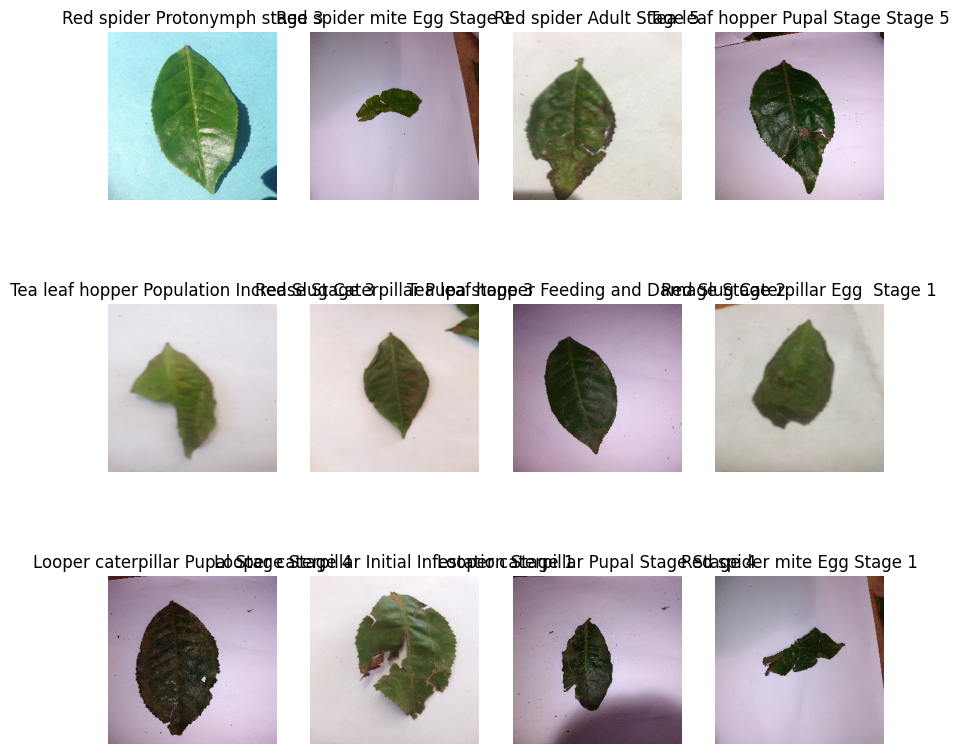

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)
len(val_ds)
len(test_ds)

4

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 21

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100


23/23 [==============================] - 71s 2s/step - loss: 3.0478 - accuracy: 0.0392 - val_loss: 3.0443 - val_accuracy: 0.0781
Epoch 2/100
23/23 [==============================] - 29s 1s/step - loss: 3.0449 - accuracy: 0.0573 - val_loss: 3.0414 - val_accuracy: 0.0781
Epoch 3/100
23/23 [==============================] - 28s 1s/step - loss: 3.0465 - accuracy: 0.0559 - val_loss: 3.0444 - val_accuracy: 0.0625
Epoch 4/100
23/23 [==============================] - 28s 1s/step - loss: 3.0358 - accuracy: 0.0825 - val_loss: 3.0233 - val_accuracy: 0.0625
Epoch 5/100
23/23 [==============================] - 28s 1s/step - loss: 2.9759 - accuracy: 0.0923 - val_loss: 2.9345 - val_accuracy: 0.0781
Epoch 6/100
23/23 [==============================] - 27s 1s/step - loss: 2.8348 - accuracy: 0.0979 - val_loss: 2.8188 - val_accuracy: 0.1094
Epoch 7/100
23/23 [==============================] - 31s 1s/step - loss: 2.6823 - accuracy: 0.1273 - val_loss: 2.7158 - val_accuracy: 0.1250
Epoch 8/100

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

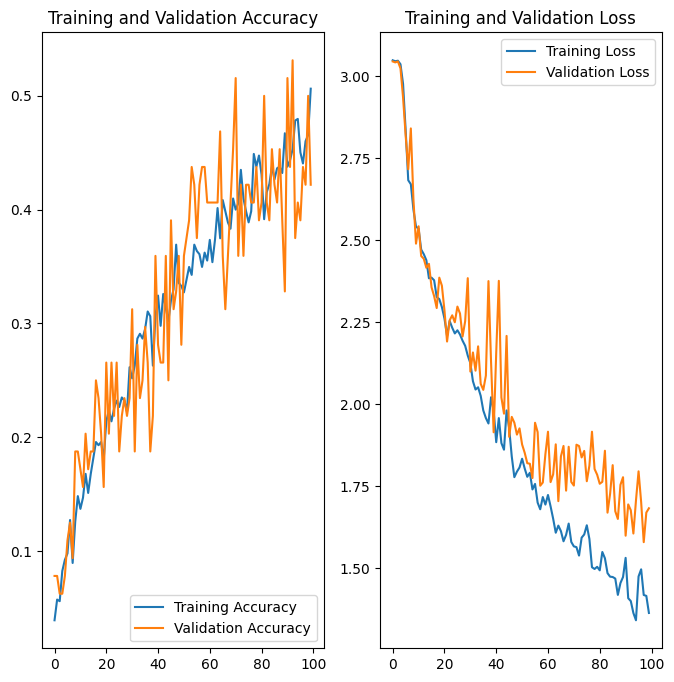

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tea leaf hopper Pupal Stage Stage 5
1/1 [==============================] - 2s 2s/step
predicted label: Tea leaf hopper Pupal Stage Stage 5


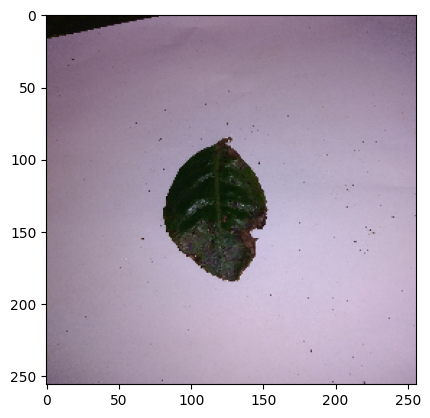

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


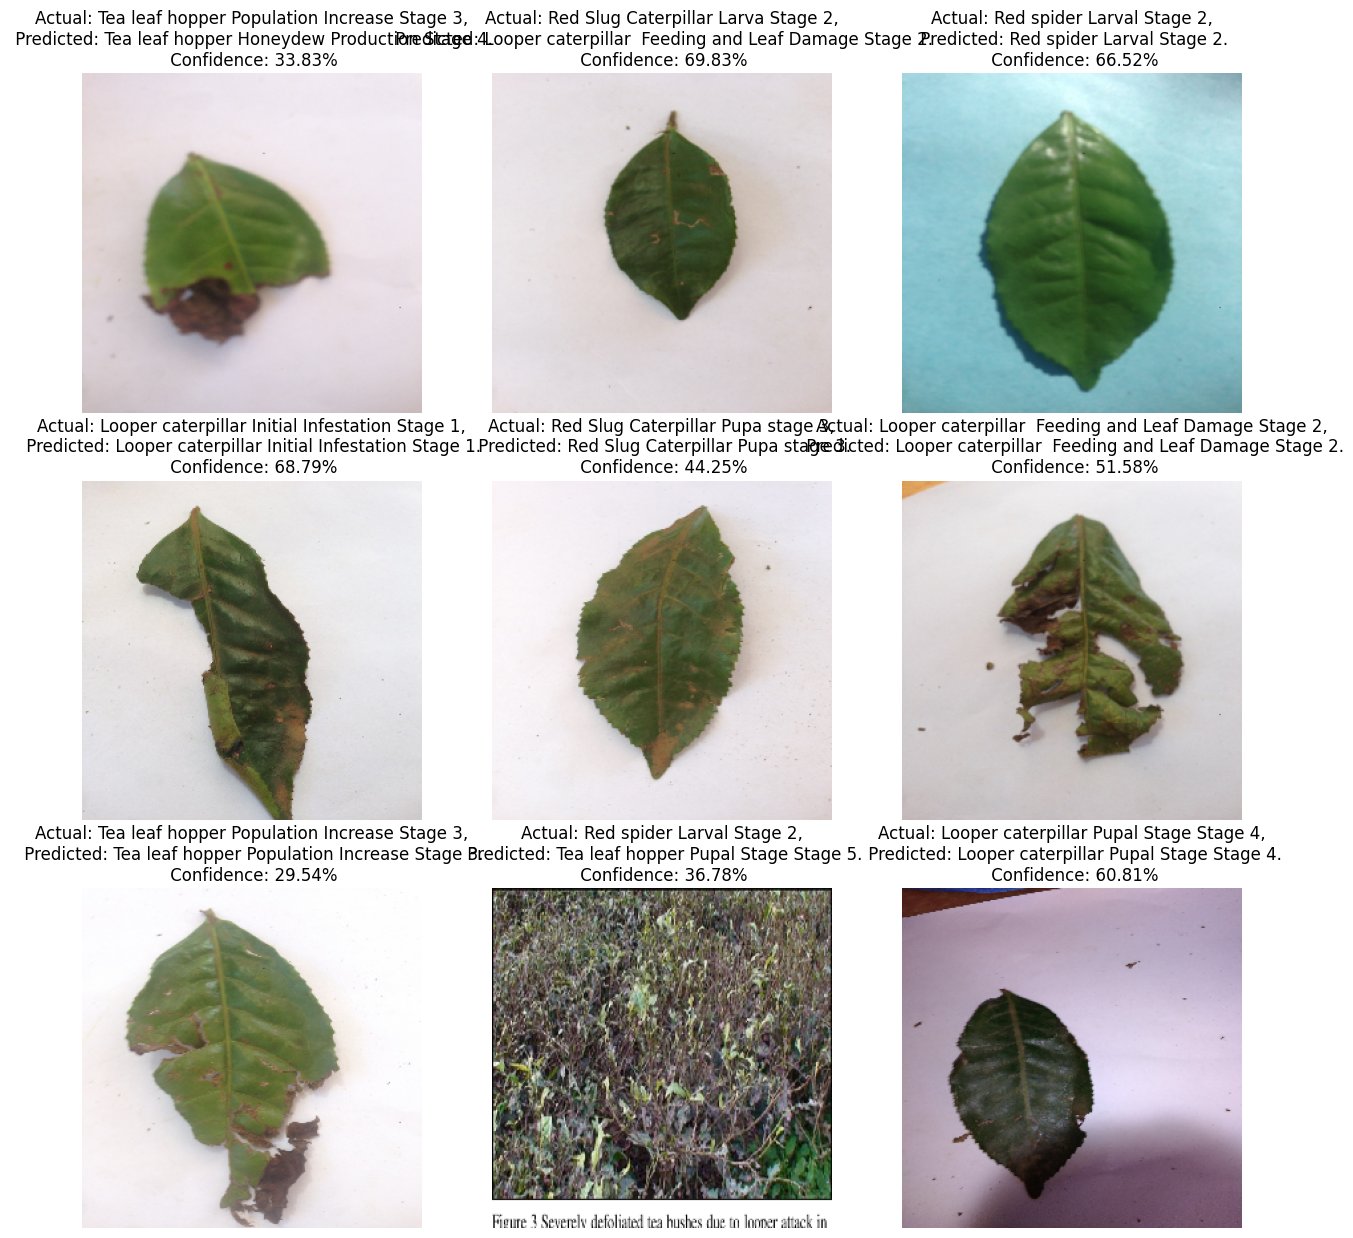

In [26]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
        

In [27]:
model.save("../mtealeafdiseasesample.h5")

c:\Users\prave\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
